# Frequentist & Bayesian Statistics With Py4J & PyMC3
-----

__[1. Introduction](#first-bullet)__

__[2. Sampling A Distribution Written In Scala Using Py4J](#second-bullet)__

__[3. The Maximum Likelyhood Estimator](#third-bullet)__

__[4. Confidence Intervals From Fisher Information](#fourth-bullet)__

__[5. Bayesian Esimatators & Credible Intervals With PyMC3](#fifth-bullet)__

__[6. Connecting The Two Methods & Conclusions](#sixth-bullet)__


## Introduction <a class="anchor" id="first-bullet"></a>
-------------

In this post I want to go back to the basics of statistics, but with an advanced spin on things. By "advanced spin" I mean, both from in terms of mathematics and computational techniques. The topic will dive into is:

    Estimating a single parameter value from a distribution and then quantifying the uncertantity in the estimate.
    
In general I will take two approaches to quantitfying the uncertainity in the estimate, the first of which is [frequentist](https://en.wikipedia.org/wiki/Frequentist_inference) and second that is [Bayesian](https://en.wikipedia.org/wiki/Bayesian_statistics).  I should admit, I am seasoned using Bayesian methods and that's why I'll be sticking to a simple example of estimating the mean rate or $\lambda$ in a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#) from sampled data.


From the computational perspective, I wanted to do something different and decided to write the probability distribution for generating the data in [Scala](https://www.scala-lang.org/), but then use it with Python. Why did I do this? Well, I like Scala and enjoyed the challenge of writing a Poisson distribution using a functional approach. I also wanted to learn more about how to use [Py4J](https://www.py4j.org/) which can be used to work with functions and objects in the [JVM](https://en.wikipedia.org/wiki/Java_virtual_machine) from Python. [Apache Spark](https://spark.apache.org/) actually uses Py4J in PySpark to write Python wrappers for their Scala API. I've used both PySpark and Spark in Scala extensively in the past and doing this project gave me an opportunity to understand how PySpark works much better.

Let's get into how I wrote the Poisson distribution in Scala and used it to sample data from in Python.

## 2. Sampling A Distribution Written In Scala Using Py4J <a class="anchor" id="second-bullet"></a>
---------------

I wrote a [Poisson distribution in Scala](https://github.com/mdh266/PoissonDistributionInScala) so that I sample data from it to estimate the mean rate $\lambda$ of that distribution. The Poisson distribution is a probability distribution for a random variable $y \, \in \, \mathbb{Z}_{+}$ that represents some count phenomena, i.e. a number of non-negative integer occurences in some fixed time frame.  For example the number of trains passing through a station per day or the number of customers that visit a website per hour can be modeled with Poisson distribution. The mathematical form of the disibution is,

$$ p(y \, = \, k)  \; = \; \frac{\lambda^{k} e^{-\lambda} }{k!} $$

The parameter $\lambda \, \in \, \mathbb{R}_{+}$ is the rate variable, i.e. the true number of customers that visit the website per hour and can be any non-negative real value.


The first step in this project was to create the Poisson class. I did this in a previous [project](https://github.com/mdh266/PoissonDistributionInScala), however, one key difference is the return value of any public function needs to be Java object. Specifically the [sample](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/Poisson.scala) method needs to return a Java List ([java.util.List[Int]](https://www.javatpoint.com/java-list)) of integers. I originally tried returning a [Scala List](https://www.scala-lang.org/api/current/scala/collection/immutable/List.html) which worked fine in pure Scala, but when returning the list to Python I got a generic "Java Object" and realized Py4J was only able to serialize specific datatypes between Python and the JVM.


In order to use this class from Python with Py4J I needed to do three things to the Scala code:

1. Create a [Gateway Server](https://www.py4j.org/_static/javadoc/index.html?py4j/GatewayServer.html)
2. Create a class entrypoint to allow for setting object attributes outside of the constructor
3. Package the code as a jar using a build tool such as [Maven](https://maven.apache.org/) or [SBT](https://www.scala-sbt.org/)


The first step is pretty straight forward to from the [Py4J Documentation](https://www.py4j.org/getting_started.html) and is in the [Main.Scala](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/Main.scala) object:

    import py4j.GatewayServer

    object Main {
        def main(args: Array[String]) = {
            val server = new GatewayServer(new PoissonEntryPoint())
            server.start()
            System.out.println("Gateway Server Started")
        }
    }
    
The GatewayServer in the author's own words *it allows Python programs to communicate with the JVM through a local network socket.*  The GatewayServer takes an *entrypoint* as a parameter which can be any object (see [here](https://www.py4j.org/getting_started.html#writing-the-python-program) for more info).  However, the entrypoint doesn't really offer a way for us to pass the $\lambda$ value from [Python](https://www.py4j.org/getting_started.html#writing-the-python-program) to the Poisson constructor in Scala. To get around this issue I created a [PoissonEntryPoint](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonEntryPoint.scala) case class:

    case class PoissonEntryPoint() {

        def Poisson(lambda : Double) : PoissonDistribution = {
            new PoissonDistribution()
        }
    }

This case class really just acts a [Singleton](https://docs.scala-lang.org/tour/singleton-objects.html), but is a class instead of an object. The point of the `PoissonEntryPoint` class is simply to be able to create a Poisson class with a specific $\lambda$ value after starting the GatewayServer.  

Now let's talk about how the project structure and packaging it for use.  The project structure is:

    src/
       main/
           scala/
               Main.scala
               PoissonDistribution.scala
               PoissonEntryPoint.scala
    pom.xml
    

The [pom.xml](https://maven.apache.org/guides/introduction/introduction-to-the-pom.html#:~:text=Available%20Variables-,What%20is%20a%20POM%3F,default%20values%20for%20most%20projects.) file is called the "project object model" and is a file that contains all the instructions for [Maven](https://maven.apache.org/). I won't go into the details here, but I will say that Maven is a Java build tool to compile and package our code and [SBT](https://www.scala-sbt.org/) is the Scala equivalent build tool. Since Scala is a [JVM language](https://en.wikipedia.org/wiki/List_of_JVM_languages) we can use either build too, however, I went with Maven since I'm more familiar with it and because it was much easier to find examples with Py4J using Maven than with SBT.

To package the code into a [uber jar](https://stackoverflow.com/questions/11947037/what-is-an-uber-jar), we can use the command:

    mvn package 
    
Then we can start our our Py4J Web server with the command:

    java -jar target/poisson-1.0-jar-with-dependencies.jar

Now we can start up our Jupyter notebook and connect Python to the JVM with the following code taken directly from [Py4J's](https://www.py4j.org/index.html#) home page

In [1]:
from py4j.java_gateway import JavaGateway

gateway = JavaGateway() 

app = gateway.entry_point

The app is now the instantiated PoissonEntryPoint class.  We can see the class type in Python

In [2]:
type(app)

py4j.java_gateway.JavaObject

As well as the methods to the class:

In [3]:
dir(app)

['Poisson',
 'apply',
 'canEqual',
 'copy',
 'equals',
 'getClass',
 'hashCode',
 'notify',
 'notifyAll',
 'productArity',
 'productElement',
 'productIterator',
 'productPrefix',
 'toString',
 'unapply',
 'wait']

We can see `Poisson` class method! Since PoissonEntryPoint is a [case class](https://docs.scala-lang.org/tour/case-classes.html) it comes with a number of default methods just like a [data class](https://realpython.com/python-data-classes/) in Python.

We can then create a Poisson class instance and see that the value of $\lambda$ is 3.0:

In [4]:
p1 = app.Poisson(1.0)
p1.getLambda()

1.0

We can then instantiate another Poisson object:

In [5]:
p2 = app.Poisson(3.0)

Note that the PoissonEntryPoint class the PoissonDistribution object is initailized within the Poisson function and not as attribute of the class. If the it were an attribute of the class it would the last commnand would change the $\lambda$ of p1.  We can see the seperate values of $\lambda$s:

In [6]:
p1.getLambda()

1.0

In [7]:
p2.getLambda()

3.0

The really nice thing about Py4J *is that you can treat objects in the JVM as if they are Python objects.* For instance we can see the methods in the object:

In [8]:
dir(p1)

['$anonfun$cdf$1',
 '$anonfun$getSum$1',
 '$anonfun$invCDF$1',
 '$anonfun$invCDF$2',
 '$anonfun$invCDF$3',
 '$anonfun$invCDF$4',
 '$anonfun$sample$1',
 '$anonfun$uniform$1',
 '$lessinit$greater$default$1',
 'cdf',
 'equals',
 'getClass',
 'getLambda',
 'getSum',
 'hashCode',
 'invCDF',
 'notify',
 'notifyAll',
 'prob',
 'sample',
 'setLambda',
 'toString',
 'uniform',
 'wait']

We can then just use the methods in the class just like they would be used directly in Scala. For instance we can get the probability of $y=1$ when $\lambda = 3$:

In [9]:
p1.prob(1)

0.36787944117144233

Now let's generate a random samle from the Poisson object:

In [10]:
sample = p1.sample(1000)

In [11]:
sample[:3]

[1, 0, 0]

It looks like Py4J returns a Python list while the [PoissonDistribution class](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonDistribution.scala) returns a  `java.util.List[Int]`:

In [240]:
type(sample)

py4j.java_collections.JavaList

We can then convert it to a Python list

In [241]:
type(list(sample))

list

Py4J can only serialize specific Java objects back to Python which is awesome!  This is also why I needed to convert to from a Scala `List[Int]` to a `java.util.List[Int]`, without it the returned object would just be a genera `Java Object`.

Now we can sample, we can visualize the Poission distribution for different values of $\lambda$

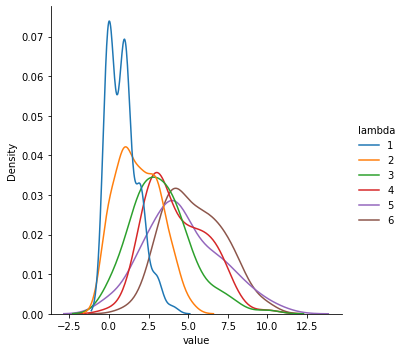

In [15]:
import pandas as pd
import seaborn as sns

df = pd.melt(
        pd.DataFrame({
            '1':list(app.Poisson(1.0).sample(100)),
            '2':list(app.Poisson(2.0).sample(100)),
            '3':list(app.Poisson(3.0).sample(100)),
            '4':list(app.Poisson(4.0).sample(100)),
            '5':list(app.Poisson(5.0).sample(100)),
            '6':list(app.Poisson(6.0).sample(100))
        }),
        var_name=["lambda"]
)

sns.displot(df, x="value", hue="lambda", kind='kde', height=5)

Note that the negative values are not real and an artifaction caused by interpolation with [Kernel Density Esimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

We can verify this:

In [16]:
df.query("value < 0")

,lambda,value


Now let's get into the Maximum Likelyhood Estimator to estimate the $\lambda$ for the distribution `p1`.

## 3. The Maximum Likelyhood Estimator <a class="anchor" id="third-bullet"></a>
---------- 

First what is the difference between a statistic and an estimator?  A statistic is any function of a sample.  An **estimator** is any function of a sample that is used to estimate a population parameter.  The **maximum likelyhood estimator** is the value of a population distribution $\lambda$ that maximizes the probability of observing the sample.  


We can find the MLE from a random sample $y_1, y_2, \, \ldots \,, y_{n}$ from $f(y_{i} \vert \, \lambda)$ then the **likelyhood function** is defined as,

$$ L(\lambda  \, \vert y_1, \, y_2, \, \ldots, \, y_n)  \; = \; \prod_{i=1}^{n}f(y_{i} \, \vert \, \lambda) $$


Then we can find the MLE $\widehat{\lambda}$ such that, 

$$ 
\hat{\lambda}_{n} \; = \; \max_{\lambda} \, L(\lambda \, \vert \, y_1, y_2, \ldots, \, y_n)
$$

From calculus we know that we can find the maximum (or minimum) of any function by solving,

$$ 
\frac{\partial L(\lambda \, \vert y_1, y_2, \ldots, y_n)}{\partial \lambda}  \; = \; 0 
$$


for $\lambda$.  The MLE has many important properties, the most important in my mind are some are,

1. It is a consistent estimator.
2. It is invariant, if $\widehat{\lambda}$ is the MLE of $\lambda$, then for any function $\tau(\lambda)$, the MLE of $\tau(\lambda)$ is $\tau(\widehat{\lambda})$.
3. The MLE is an asymptotically normal estimator.  That is $\widehat{\lambda} \; \sim \; N(\lambda, \, \mathcal{I}^{-1/2})$. 

To explain the first property we, must note that since an estimator is a function of the sample space it is also a random variable [random variable](https://en.wikipedia.org/wiki/Random_variable).  Let $X_1, \, \ldots, \, X_n$ be a sequence of random variables then $X_{i} \; \xrightarrow{\mathcal{P}} \; X$ if,

$$\forall \epsilon > 0, \; \lim\limits_{n \rightarrow \infty} P(\vert X_i - X \vert > \epsilon ) \; = \; 0$$ 

then we say the random variable converges in probability. For an estimator this property of convergence is called **consistency**. Consistency is a necessary condition of any estimator in statistics and basically signifies that estimator eventually settles down to constant or some probability distribution of values. 

The second property of the MLE allows us to transform our likelyhood function into one that is easier to calculate the MLE with, i.e. the log-likelyhood function. That is the MLE, $\hat{\lambda}$ will satisfy, 

$$ \frac{\partial \log(L(\lambda \, \vert y_1, \, \ldots, y_n ))}{\partial \lambda}  \; = \; 0 $$


The third property of asymptotic normality of the MLE is helpful in modeling, since your standardized residuals are normal. Hence the sum of squares of the residuals are $\chi^2$ distributed.  This allows us to define confidence intervals around of estimates. The term $\mathcal{I}^{-1/2}$ is the [Fisher Information](https://en.wikipedia.org/wiki/Fisher_information) and will be discussed in the next section.


For the Poisson distribution the likelyhood function is,

$$
\begin{align} L(\lambda  \, \vert y_1, \, y_2, \, \ldots, \, y_n)  
\; &= \; 
\prod_{i=1}^{n} \frac{e^{-\lambda} \, \lambda^{y_i}} {y_i!} \newline
&= \; 
e^{-n \, \lambda} \lambda^{n \, \bar{y}_{n}}  \frac{1} {\prod_{i=1}^{n} y_i!}
\end{align}
$$

We take the log of both sides and then setting the derivative equal to zero we find


$$
- n  \,  + \, \frac{n \, \bar{y}_{n}}{\widehat{\lambda}} \, = \, 0
$$

Then solving for $\hat{\lambda}$ we find the MLE is,


$$ \widehat{\lambda} \, = \, \bar{y}_{n} $$


In [242]:
from typing import List

def mle(sample : List[int]) -> float:
    converted = list(sample)
    return sum(converted) / len(converted)

lam = mle(p2.sample(1000))

print(f"lambda = {lam}") 

lambda = 2.975


Our estimate for $\lambda$ is pretty close to the true value of 3! 

Now, since the maximum likelihood estimator is the mean we know it satifies the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem),


$$ \hat{\lambda} _{n}\, = \, \bar{y}_{n} \; \xrightarrow{\mathcal{D}} \; N(\lambda,\lambda/n) $$

Hence we can repeatedly sample `p1` and compute the distribution of the MLE for various values of sample size $n$ to show how the MLE converges in distribution.

In [21]:
import numpy as np

In [72]:
# sample the MLE 100 times for each n = 10, 50, 100, 500, 1000
samples = [ [ mle(p2.sample(n)) for k in range(100)] for n in [10, 20, 50, 100, 200, 500, 1000]]

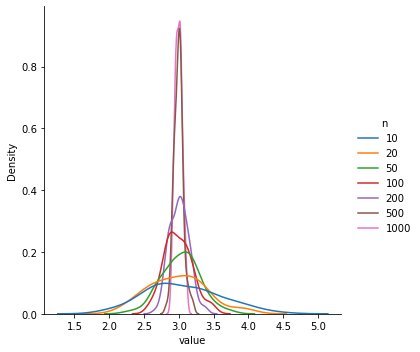

In [73]:
sample_df = pd.melt(
                pd.DataFrame(np.array(samples).T, 
                             columns=['10', '20', '50','100', '200', '500', '1000']),
                var_name=["n"]
)

# # plot the MLE for various value of sample size
sns.displot(sample_df, x="value", hue="n", kind="kde", height=5,)

As $n \rightarrow \infty$ we see the MLE $\bar{y}_{n}$ has a distribution that is more sharply peaked around $3$ and hence shows that the esimator is converging to the true value!

We have seen that the MLE $\widehat{\lambda_{n}}$ converges to the true value of $\lambda$, but for any finite value of $n$ the esimator can be incorrect.  How to we measure our confidence in our estimator $\widehat{\lambda_{n}}$?  The answer is through confidence intervals and Fisher interval.

## 3. Confidence Intervals From Fisher Information <a class="anchor" id="fourth-bullet"></a>
-------------------
Given a distribution $y_{i} \, \sim \, f(y \, \vert \, \alpha)$ for $i \, = \, 1, \ldots , n$ and the likelyhood function,

$$ L(\alpha \, \vert \, y_1, y_2, \ldots, y_n) \; = \; \prod_{i=1}^{n} \,  f(y_i \, \vert \, \alpha) $$

We define the [score statistic](https://en.wikipedia.org/wiki/Score_(statistics)) $S(\alpha)$ to be,

$$
S(\alpha) \; = \; \frac{d\log \left(L(\alpha \, \vert  \, y_1, y_2, \ldots, y_n) \right)}{d\alpha} 
$$

For a distribution from the [exponential family](https://en.wikipedia.org/wiki/Exponential_family) the score function satisfies,

$$
E_{y}[S] \; = \; 0
$$

Another important property of the score statistic is that it satisfies,

$$ S(\widehat{\alpha})  \; = \; 0$$

for the MLE $\widehat{\alpha}$.  This property can be used to compute the MLE using the so-called [scoring algorithm](https://en.wikipedia.org/wiki/Scoring_algorithm) which is equivalent to [Newton–Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method). The later method is more frequently used in calculations as it general optimization method and has many efficient implmentations.

The [**Fisher information**](https://en.wikipedia.org/wiki/Fisher_information) is defined as,

\begin{align}
\mathcal{I} \; &= \; \text{Cov}[S] \\
& = \; \text{Var}[ S S^{T}] \\
& = \; E_y[ - S'] \\
 &= \; E_{y} \left[  - \frac{d^{2}\log \left(L(\alpha \, | \, y_1, y_2, \ldots, y_n) \right)}{d\alpha^{2}}  \right] 
\end{align}

One can show that the standard error for the maximum likelihood estimate $(\widehat{\alpha}_{n})$ will then be,

$$ \text{S.E.}(\widehat{\alpha}_{n}) \; = \; \frac{1}{\sqrt{\mathcal{I}_{n}}}$$


The curvature of the log-likelyhood at the MLE dictated by the Fisher information matrix. If $L$ flat then the $\mathbb{I}$ is small, so the MLE is not stable or well-defined.  Larger Fisher information tells us the MLE is well defined and stable.


Asymptotic normality for the MLE implies,

\begin{equation}
 \widehat{\alpha}_{n} \; \sim \; N(\alpha, \, \mathcal{I}_{n}^{-1})
\end{equation}

These facts can be used to calculate confidence intervals for the MLE,

$$\text{CI}_{\alpha} \, = \, [ \widehat{\alpha} - Z_{\alpha/2} \, \mathcal{I}^{-1}/\sqrt{n}, \, \widehat{\alpha} + Z_{\alpha/2} \, \mathcal{I}^{-1} /\sqrt{n}]$$


The Fisher information for a Poisson distribution is,

$$ \mathcal{I} \, = \, 1/\lambda $$

This means for our MLE of the Poisson distribution the confidence interval will be: 

$$\text{CI}_{\hat{\lambda}} \, = \, [ \bar{y}_{n} - Z_{\alpha/2} \, \sqrt{\bar{y}_{n} / n}, \, \bar{y}_{n} + Z_{\alpha/2} \, \sqrt{\bar{y}_{n}/ n}]$$


We can then come up with a functin to compute the 94% confidence interval for the sample:

In [243]:
from typing import Tuple 

def ci(sample : List[int]) -> Tuple[float,float]:
    """
    Computes the 94% confidence interval for sampled
    data from a Poisson distribution
    """
    z = 1.88
    m = mle(sample)
    n = len(sample)
    return (m - z*np.sqrt(m/n), m + z*np.sqrt(m/n))

We can then get the MLE for the sampled data from Poisson(1.0)

In [244]:
mle(sample)

0.998

The 94% confidence interval is then,

In [245]:
ci(sample)

(0.9386086605640183, 1.0573913394359817)

We can see that the confidence interval does contain the true $\lambda \, = \, 1$. Many people think a 94% confidence interval, $\text{CI}_{94}$, can be used to say that there is a 94% probability that the $\lambda$ is in the confidence interval $\text{CI}_{94}$.  This interpetation is wrong, in frequentist methods, the parameter $\lambda$ is assumed to be a fixed, but unknown value. One cannot make probability statements about fixed values. 

The confidence interval is a function of the sample space and therefore a random variable. One can make probability statements about the confidence intervals. Indeed the correct interpretation is that if you are able to repeatedly re-sample the population distribution $f(y \, \vert \, \lambda)$ to form many confidence intervals $\text{CI}_{94}$, 94% of them would contain the true population parameter $\lambda$.

We can test this by creating a function which returns a boolean indicating whether or not the parameter `lam` is contained in the 94% confidence interval from the data `sample`:

In [ ]:
def in_ci(lam : float, sample : List[Int]) -> bool:
    interval = ci(sample)
    return (lam >= interval[0] and lam <= interval[1])

We can then test this function:

In [40]:
in_ci(1, sample)

True

In [53]:
in_ci(3, sample)

False

Then we can loop over 1,000 confidence interval to see how many times they capture the true rate parameter:

In [52]:
count_in_ci = [1 if in_ci(1, p1.sample(1000)) else 0 for i in range(1000)]
print("Confidence interval captures true rate {}% of times".format(100*sum(count_in_ci)/len(count_in_ci)))

Confidence interval captures true rate 93.7% of times


This is nearly spot on to what the theory says!

Let's now move on to Bayesian methods!

# Bayesian Esimatators & Credible Intervals With PyMC3 <a class="anchor" id="fifth-bullet"></a>
-----------

In the frequentist approach the parameter we wish to estimation $\lambda$ is fixed, but unknown.  The observed data $\left\{ y_1, y_2, \ldots, y_n \right\}$ is assumed to be from a population $f(y \, \vert \, \lambda)$ and estimates about the value of the population paremeter $\lambda$ is obtained by using the maximum likelyhood. As we discussed above, probability statements about the unknown rate constant $\lambda$ don't make sense as its a fixed value and not random variable.  However, probability statements can be made about a confidence interval for $\lambda$. In the maximum likely method, asympotic normality allows us to use confidence intervals as a way to quantify the uncertaintity in our estimator which was calculated from the data.

In contrast, in Bayesian statistics, $\lambda$ is not a fixed value, but assumed to have values coming from a probability distribution called the [prior](https://en.wikipedia.org/wiki/Prior_probability), $P(\lambda)$. This is often subjective and the choice of distribution for the prior often comes from domain knowledge.  The observed data $\left\{ y_1, y_2, \ldots, y_n \right\}$ is a sample taken from a population and used to update the prior distribution, now called the [posterior distribution](https://en.wikipedia.org/wiki/Posterior_distribution), $P(\lambda \, \vert \, y_1, y_2, \ldots, y_n )$. We can formulate estimators for $\lambda$ and quanitify the uncertaintity in those esimates by directly using the posterior distribution. 

Let $f(y_1, y_2, \ldots, y_n \, \vert \, \lambda )$ be the sampling distribution then the posterior distribution then [Baye's theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) states,

$$ P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)
 \; = \; 
\frac{ P ( y_1, y_2, \ldots, y_n \, \vert \, \lambda) \, P(\lambda)}{m(y_1, y_2, \ldots, y_n)}, \quad \text{and} \qquad m(y_1, y_2, \ldots, y_n) \; = \; \int P ( y_1, y_2, \ldots, y_n\, \vert \, \lambda) \, P(\lambda) \, d\lambda
$$
 

Where $m(y_1, y_2, \ldots, y_n)$ is called the marginal distribution and used for normalization. Bayes rule can also be rewritten as using the likelyhood function $L(\lambda \, \vert \, y_1, y_2, \ldots, y_n)$:


$$ P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)
 \; = \; 
\frac{ L(\lambda \, \vert \, y_1, y_2, \ldots, y_n) \, P(\lambda)}{m(y_1, y_2, \ldots, y_n)}
$$

The [Bayesian estimator](https://en.wikipedia.org/wiki/Bayes_estimator) (often called the posterior mean) is  taken the be the expected value over the the random variable $y$:
 
$$ \widehat{\lambda} \; = \; E_{y}(\lambda \, \vert \, y_1, y_2, \ldots, y_n)$$
 

Until the advant of computers, statisticians stuck to using [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) in Bayesian methods since there are analytic solutions for the posterior distribution.

If we were to assume our prior was [Gamma distributed](https://en.wikipedia.org/wiki/Gamma_distribution) for $\alpha, \beta > 0$:

$$
P(\lambda \, \vert \, \alpha, \beta ) \; = \; \frac{\beta^{\alpha }}{(\alpha-1)! }  \, x^{\alpha-1} \, e^{-\beta y}
$$

A depiction of the Gamma distribution for various values of $\alpha$ and $\beta$ can be seen from [PyMC3's website](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

![](https://docs.pymc.io/api/distributions/continuous-6.png)

Then the posterior is [again a Gamma distribution](https://people.stat.sc.edu/Hitchcock/slides535day5spr2014.pdf), but with $\alpha^{\prime} \, = \, \alpha \, + \, n$ and $\beta^{\prime}  \, = \, \bar{y}_{n}, \,  \beta \, + \, n$. This leads to a posterior mean for original,


$$\hat{\lambda} \; = \; \frac{\alpha}{\beta \, + \, n} 
\, + \, \frac{ \bar{y}_{n}}{1 \, + \, \beta \, / \, n\, }$$

We can see that with little data (small $n$) our estimate we are closer to the prior mean ($\frac{\alpha}{\beta}$) while with lots of data (large $n$) we move towards the average $\bar{y}_{n}$.

In [104]:
def posterior_mean(alpha, beta, sample):
    n = len(sample)
    m = sum(sample) / n
    
    return alpha / (beta + n) + m  / (1 + beta / n)

In [105]:
from random import randint

In [106]:
nums_samples = [randint(2,1000) for i in range(1000)]
nums_samples.sort()

In [109]:
samples = [ posterior_mean(alpha=3.0, beta=1.0, sample = p1.sample(n)) 
           for n in nums_samples]

<AxesSubplot:title={'center':'Covergence of Posterior Mean'}, xlabel='sample_size'>

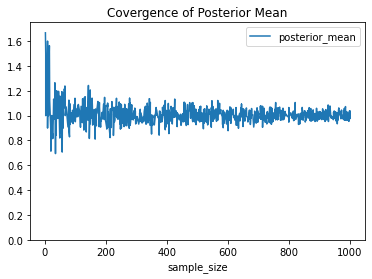

In [218]:
(pd.DataFrame({
    "posterior_mean":samples, 
    "sample_size":nums_samples
}).plot(x="sample_size", 
        y="posterior_mean", 
        title="Covergence of Posterior Mean", 
        ylim=(0,1.75)))

The anology of confidence in Bayesian esimation is called the [Credible Interval](https://en.wikipedia.org/wiki/Credible_interval) which requires the full posterior:

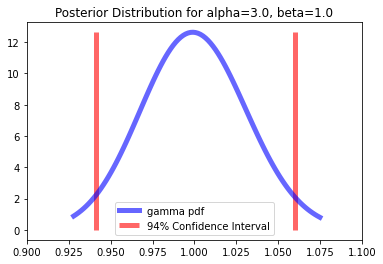

In [226]:
from gamma import posterior_distribution

alpha = 3.0
beta = 1.0
posterior_distribution(alpha, beta, sample)

In [228]:
import pymc3 as pm
import arviz as az

/Users/mukeharmon/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [229]:
with pm.Model() as model_1:
    λ = pm.Gamma('λ', alpha=3, beta=1)
    y = pm.Poisson('y', mu=λ, observed=list(sample))
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 22 seconds.


In [230]:
az.summary(trace,kind="stats")

,mean,sd,hdi_3%,hdi_97%
λ,0.998,0.031,0.945,1.059


<AxesSubplot:title={'center':'λ'}>

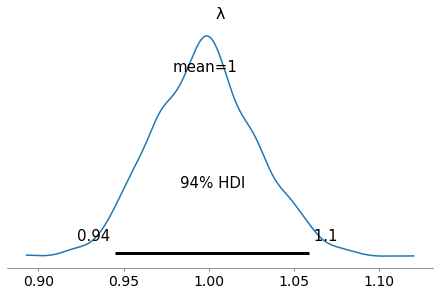

In [231]:
az.plot_posterior(trace)

As we saw the Bayesian estimator requires the full posterior distribution. Without a conjugate prior Bayesian methods requires numerical approximation to the posterior which computationally expenisve. Despite the added complexity, Bayesian methods allows to handle situations where we might not have access to much data. One way to get the posterior distribution is to sample the the prior distribution and then evaluate the likelyhood of the data that:


In [309]:
mle(sample[:50])

0.86

In [310]:
ci(sample[:50])

(0.6134403114862448, 1.1065596885137552)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 19 seconds.


array([[<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>]], dtype=object)

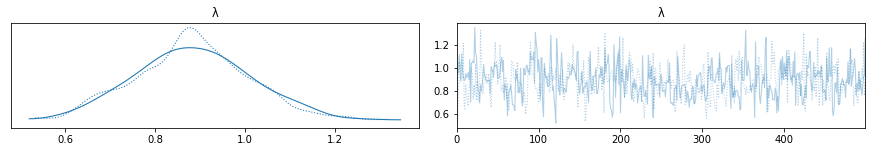

In [323]:
with pm.Model() as model_2:
    λ = pm.Exponential('λ', 0.1)
    y = pm.Poisson('y', mu=λ, observed=list(sample[:50]))
    trace2 = pm.sample(500, cores=2, return_inferencedata=True)

az.plot_trace(trace2, var_names=['λ'])

In [324]:
az.summary(trace2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
λ,0.887,0.139,0.624,1.142


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.


array([[<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>]], dtype=object)

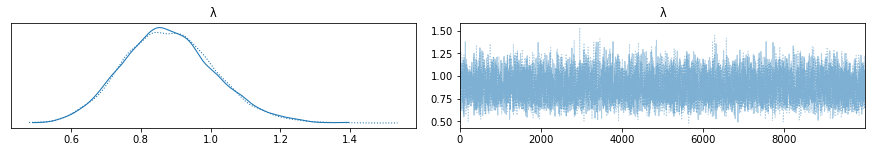

In [325]:
with model_2:
    trace3 = pm.sample(10000, cores=2, return_inferencedata=True)

az.plot_trace(trace3, var_names=['λ'])

In [326]:
az.summary(trace3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
λ,0.881,0.132,0.623,1.119


In [327]:
pm.find_MAP(model=model_2)

{'λ_log__': array(-0.15282089), 'λ': array(0.85828343)}

# Connecting The Two Methods & Conclusions <a class="anchor" id="sixth-bullet"></a>
------

Instead, one could use a Bayesian estimator that is called the [Maximum A-Posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation):
 
  $$ \widehat{\lambda} \; = \; \max_{\lambda} P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)$$
 

In [330]:
with pm.Model() as model_3:
    λ = pm.Uniform('λ', lower=0, upper=10)
    y = pm.Poisson('y', mu=λ, observed=list(sample))
    
pm.find_MAP(model=model_3)

{'λ_interval__': array(-2.19944878), 'λ': array(0.998)}

We should note that Bayesian estimators are ALWAYS biased due to their choice of prior, however, they can reduce the variance in our estimators.

https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem